<a href="https://colab.research.google.com/github/Xixianghu202124213/Capstone/blob/main/ARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF
import numpy as np
%matplotlib inline
import csv
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA




/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


           MATERIAL_NUMBER PLANT  QUANTITY
DATE                                      
2015-01-05               H    X2         0
2015-01-06               H    X2         5
2015-01-07               H    X2         2
2015-01-08               H    X2       260
2015-01-09               H    X2         9
...                    ...   ...       ...
2020-01-01               H    X2         0
2020-01-02               H    X2        33
2020-01-03               H    X2        27
2020-01-04               H    X2         0
2020-01-05               H    X2         0

[1827 rows x 3 columns]


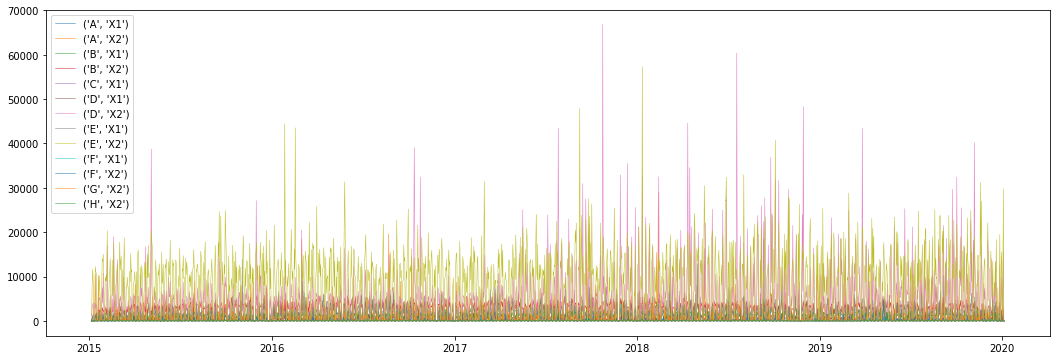

In [2]:

csvfile = open('/content/drive/MyDrive/Data/historical_orders.csv','r')
reader = [each for each in csv.DictReader(csvfile, delimiter=';')]
df = pd.DataFrame(reader)

df["DATE"]=pd.to_datetime(df["DATE"],format="%d.%m.%Y")
df.set_index('DATE',inplace=True)
groups=df.groupby(["MATERIAL_NUMBER","PLANT"])
group_list=list(groups)
group_list
from pandas import DataFrame
ax,fig=plt.subplots(figsize=(18,6))
series=DataFrame()
for key,df in groups:
    series=df.copy()
    series.iloc[:,2]=series.iloc[:,2].astype(int)
    plt.plot(series.index,series.iloc[:,2],linewidth=0.5,label=key)
    plt.legend()
   # print(type(df))
print(series)

#for i in range(len(group_list)):


In [4]:
GDP=pd.read_csv('/content/drive/MyDrive/Data/GDP.csv')
GDP.columns
GDP.set_index('0',inplace=True)
GDP=GDP[(GDP.index>='2015-01-05')&(GDP.index<='2020-01-05')]
GDP.index.name=None

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [83]:
def ARIMA_Model(timeseries,order):
    model = ARIMA(timeseries,exog=GDP_train,order=order)
    return model.fit()

In [7]:
def log(timeseries):
  timeseries_log=np.log(timeseries).replace(float("-inf"), 0)
  return timeseries_log

In [137]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model_method2(timeseries, arima_order):
  train_size = int(len(timeseries)*0.9)
  train, test = timeseries[0:train_size],timeseries[train_size:]
  mae=float("inf")
  try:

    model = ARIMA_Model(train,arima_order)
    mae=np.mean(np.abs(model.resid))
  except:
    pass
  return mae

In [136]:
def gridsearch(timeseries):
  series_pdq=[]
  series_mse=[]
  train_size=int(len(timeseries)*0.9)
  train=timeseries[0:train_size]
  test=timeseries[train_size:]
  best_score = float("inf")
  best_pdq=None
  for p in range(8):
    for d in range(3):
        for q in range(8):  
          order=(p,d,q)
          print(str(order))
          try:
            mae=evaluate_model_method2(timeseries,order)
            if mae<best_score:
              
              best_score=mae
              best_pdq=order
              print("MAE",best_pdq,best_score)
          except:
              pass
  return best_pdq

In [138]:
def model_fit(seasonal,trend,residual,tr_pdq,re_pdq):
  train_size=int(len(trend)*0.9)
  test=seasonal[train_size:]

  tr_p,tr_d,tr_q=tr_pdq[0],tr_pdq[1],tr_pdq[2]
  trend_model = ARIMA_Model(trend[0:train_size],(tr_p,tr_d,tr_q))

  trend_fit_seq = trend_model.fittedvalues

  re_p,re_d,re_q=re_pdq[0],re_pdq[1],re_pdq[2]
  residual_model = ARIMA_Model(residual[0:train_size],(re_p,re_d,re_q))
  residual_fit_seq = residual_model.fittedvalues

  fit_seq = pd.Series(seasonal[0:train_size], index=seasonal[0:train_size].index)
  fit_seq = fit_seq.add(trend_fit_seq, fill_value=0)
  fit_seq = fit_seq.add(residual_fit_seq, fill_value=0)

  trend_predict_seq = trend_model.predict(start='2019-07-07',end='2019-08-07',exog=GDP_test[0:32],dynamic=True)
  residual_predict_seq = residual_model.predict(start='2019-07-07',end='2019-08-07',exog=GDP_test[0:32],dynamic=True)
  seasonal_predict_seq=seasonal['2018-07-01':'2018-08-01']
  
  seasonal_predict_seq.index = test[0:32].index
  predict_seq = pd.Series(seasonal_predict_seq, index=seasonal_predict_seq.index)
  
  predict_seq = predict_seq.add(trend_predict_seq, fill_value=0)
  print(len(predict_seq))
  predict_seq = predict_seq.add(residual_predict_seq, fill_value=0)


  return fit_seq,predict_seq


In [13]:
def pre_month(sequence,title,test,tr_pdq,re_pdq):
  mae=np.mean(np.abs(sequence.values-test[0:32]))
  plt.figure(figsize=(20, 8))
  plt.plot(sequence, color='red', label='predict_seq')
  plt.plot(test[0:32], color='blue', label='test_seq')
  plt.legend(loc='best')
  plt.title("Trend Model:"+str(tr_pdq) +" Residual Model: "+str(re_pdq)+"  MSE: %f"%(mae,))
  plt.suptitle(str(title)+"MONTH")
  name="/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/ARIMAX_Plot/"+str(title)+'_predict(Month).png'
  plt.savefig(name)
  plt.show()


In [14]:
def pre_week(sequence,title,test,tr_pdq,re_pdq):
  mae=np.mean(np.abs(sequence.values-test[0:8]))
  plt.figure(figsize=(20, 8))
  plt.plot(sequence, color='red', label='predict_seq')
  plt.plot(test[0:8], color='blue', label='test_seq')
  plt.legend(loc='best')
  plt.title("Trend Model:"+str(tr_pdq) +" Residual Model: "+str(re_pdq)+"  MSE: %f"%(mae,))
  plt.suptitle(str(title)+"WEEK")
  name="/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/ARIMAX_Plot/"+str(title)+'_predict(week).png'
  plt.savefig(name)
  plt.show()

In [15]:
def fit_plot(sequence,title,train,tr_pdq,re_pdq):
  train_size=int(len(train)*0.9)
  #train_size=1200
  #train=train[0:train_size]
  mse = mean_squared_error(train, sequence)
  plt.figure(figsize=(20, 8))
  plt.plot(sequence[len(sequence)-365:len(sequence)], color='red', label='fit_seq')
  plt.plot(train[len(sequence)-365:len(sequence)], color='blue', label='original_seq')
  plt.legend(loc='best')
  plt.title("Trend Model:"+str(tr_pdq) +" Residual Model: "+str(re_pdq)+"  MSE: %f"%(mse,))
  plt.suptitle(title)
  name="/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/ARIMAX_Plot/"+str(title)+'_month_simulation.png'
  plt.savefig(name)
  plt.show()

In [16]:
def recover(series):
  recover_seq= np.exp(series)
  recover_seq.dropna(inplace=True)
  return recover_seq

In [ ]:
residual_pdq=list()
trend_pdq=list()
index=0

for label,df in groups:
  if index<0:
    print(label)
    pass
  else:
    train_size=int(len(df)*0.9)
    
    data=df.iloc[:,2].astype('int').reset_index()
    gdp=GDP.reset_index()
    df1=pd.concat([data,gdp],axis=1).iloc[:,1:]
    df1.set_index('index',inplace=True)
    df1.index.name=None
    data=df1.iloc[:,0]
    GDP.index=GDP.index.astype('datetime64[ns]')
    GDP_train=GDP[0:train_size]
    GDP_test=GDP[train_size:]
    #series=log(data)

    series=data
    series.index=data.index.astype('datetime64[ns]')
    train=series[0:train_size]
    test=series[train_size:]

    decomposition = seasonal_decompose(series)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    trend = trend.fillna(0)
    seasonal = seasonal.fillna(0)
    residual = residual.fillna(0)

    tr_pdq=gridsearch(trend)
    re_pdq=gridsearch(residual)

    trend_pdq.append(tr_pdq)
    residual_pdq.append(re_pdq)
    
    fit_seq,pre_seq=model_fit(seasonal,trend,residual,tr_pdq,re_pdq)
    
    #recover the log sequence
    #fit_seq=recover(month_fit_seq)
    #pre_seq=recover(month_pre_seq)

    fit_plot(fit_seq,label,data[0:train_size],tr_pdq,re_pdq)
    pre_month(pre_seq,label,data[train_size:],tr_pdq,re_pdq)
    pre_week(pre_seq[0:8],label,data[train_size:],tr_pdq,re_pdq)

    #recover the log sequence
    #week_fit_seq=recover(week_fit_seq)
    # week_pre_seq=recover(week_pre_seq)

    #plt.figure(figsize=(12, 6))
    #plt.plot(seasonal,label='Seasonarity')#all are 7
    #residual_p,residual_d,residual_q,residual_aic=gridsearch(residual)
  index+=1
  break

(0, 0, 0)
MAE (0, 0, 0) 43.85030098212549
(0, 0, 1)
MAE (0, 0, 1) 30.77355972833664
(0, 0, 2)
(0, 0, 3)
(0, 0, 4)
MAE (0, 0, 4) 22.161396012516036
(0, 0, 5)
(0, 0, 6)
(0, 0, 7)
MAE (0, 0, 7) 13.683202072670747
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 0, 3)
(1, 0, 4)
(1, 0, 5)
(1, 0, 6)
(1, 0, 7)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(1, 1, 5)
(1, 1, 6)
(1, 1, 7)
(1, 2, 0)
(1, 2, 1)
(1, 2, 2)
(1, 2, 3)
(1, 2, 4)
(1, 2, 5)
(1, 2, 6)
(1, 2, 7)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 0, 3)
(2, 0, 4)
(2, 0, 5)
(2, 0, 6)
